<h4><b>Importing necessary libraries and connecting to the database</b></h4>

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
# Connect to SQLite database
conn = sqlite3.connect("../ecommerce.db")

<h4><b>Checking tables in the database</b></h4>

In [3]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,dim_products
1,dim_customers
2,dim_date
3,fact_sales
4,sqlite_sequence
5,staging_table


<h4><b>Loading the fact_sales table into Pandas</b></h4>

In [4]:
fact_sales=pd.read_sql("SELECT * FROM fact_sales",conn)
fact_sales.head()

,sales_id,invoice_no,product_id,customer_id,date_key,quantity,unit_price,revenue
0,1,536365,85123A,17850,20101201,6,2.55,15.30
1,2,536365,71053,17850,20101201,6,3.39,20.34
2,3,536365,84406B,17850,20101201,8,2.75,22.00
3,4,536365,84029G,17850,20101201,6,3.39,20.34
4,5,536365,84029E,17850,20101201,6,3.39,20.34


<h4><b>Initial data quality and consistency checks</b></h4>

In [5]:
print(fact_sales.shape)
fact_sales.describe()

(397884, 8)


,sales_id,customer_id,date_key,quantity,unit_price,revenue
count,397884.000000,397884.000000,3.978840e+05,397884.000000,397884.000000,397884.000000
mean,198942.500000,15294.423453,2.011012e+07,12.988238,3.116488,22.397000
std,114859.361591,1713.141560,2.385029e+03,179.331775,22.097877,309.071041
min,1.000000,12346.000000,2.010120e+07,1.000000,0.001000,0.001000
25%,99471.750000,13969.000000,2.011041e+07,2.000000,1.250000,4.680000
50%,198942.500000,15159.000000,2.011073e+07,6.000000,1.950000,11.800000
75%,298413.250000,16795.000000,2.011102e+07,12.000000,3.750000,19.800000
max,397884.000000,18287.000000,2.011121e+07,80995.000000,8142.750000,168469.600000


 <h4><b>Basic Revenue Distribution Histogram</b> - Shows extreme right skewness</h4>

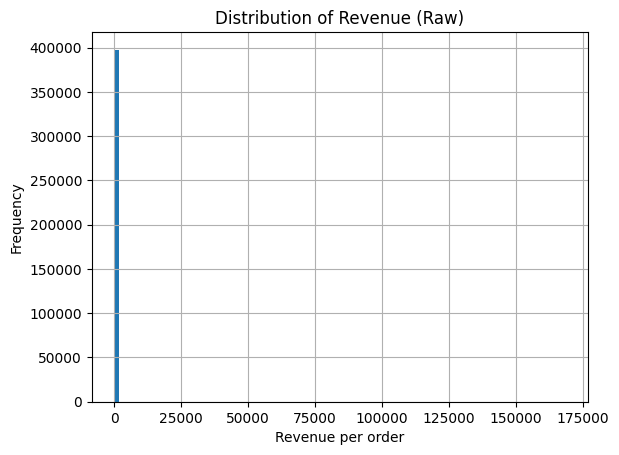

In [6]:
plt.figure()
fact_sales['revenue'].hist(bins=100)
plt.xlabel('Revenue per order')
plt.ylabel('Frequency')
plt.title('Distribution of Revenue (Raw)')
plt.show()

 <h4><b>Revenue Log Scaled Histogram </b> - To visualise revenue better</h4>

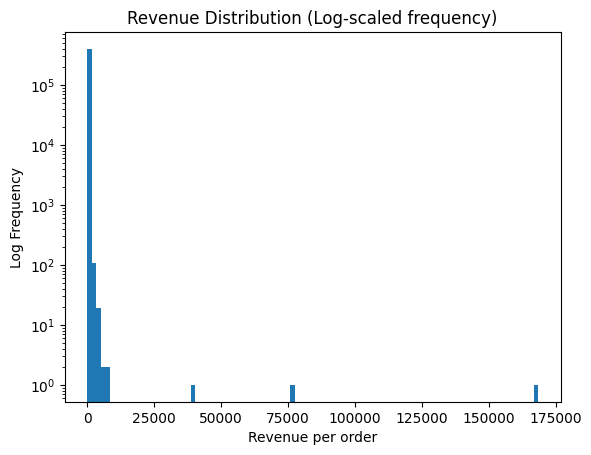

In [7]:
plt.figure()
plt.hist(fact_sales['revenue'], bins=100, log=True)
plt.xlabel('Revenue per order')
plt.ylabel('Log Frequency')
plt.title('Revenue Distribution (Log-scaled frequency)')
plt.show()

<h4><b>Checking if skewness is customer driven</b></h4>

In [8]:
customer_revenue = (fact_sales.groupby("customer_id", as_index=False)["revenue"].sum())
customer_revenue.describe()

,customer_id,revenue
count,4338.000000,4338.000000
mean,15300.408022,2054.266460
std,1721.808492,8989.230441
min,12346.000000,3.750000
25%,13813.250000,307.415000
50%,15299.500000,674.485000
75%,16778.750000,1661.740000
max,18287.000000,280206.020000


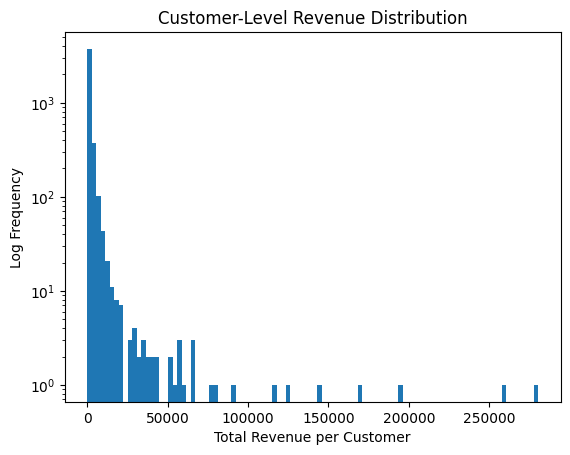

In [9]:
plt.figure()
plt.hist(customer_revenue['revenue'], bins=100,log=True)
plt.xlabel('Total Revenue per Customer')
plt.ylabel('Log Frequency')
plt.title('Customer-Level Revenue Distribution')
plt.show()


<h5>From above graph and description table we can clearly infer that the skewness is customer driven</h5>

<h4><b>Checking Purchase frequency</b></h4>

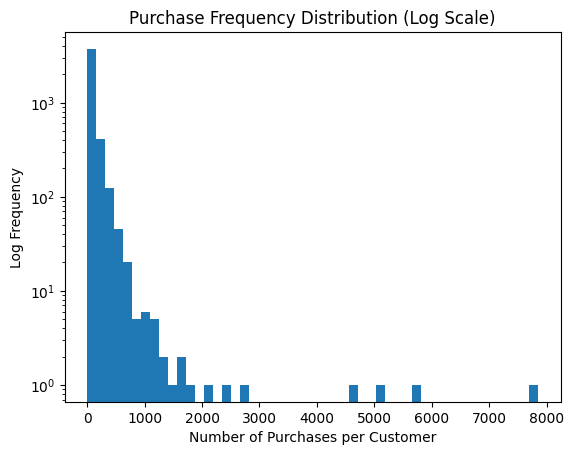

In [15]:
customer_freq = (fact_sales.groupby('customer_id').size().reset_index(name='frequency')) #calculating the customer purchase frequency
#visualising customer purchase frequency
plt.figure()
plt.hist(customer_freq['frequency'], bins=50,log=True)
plt.xlabel('Number of Purchases per Customer')
plt.ylabel('Log Frequency')
plt.title('Purchase Frequency Distribution (Log Scale)')
plt.show()



<p>the purchase frequency distribution above shows the substancial variability among customers</p>

<h4><b>Checking if recency is right censored </b>-Yes, since observation range of dataset source = observed last sales date</h4>

In [11]:
sales_with_date = fact_sales.merge(
    pd.read_sql("SELECT date_key, date FROM dim_date", conn),
    on="date_key",
    how="left"
)

sales_with_date["date"] = pd.to_datetime(sales_with_date["date"])
sales_with_date["date"].min(), sales_with_date["date"].max()

(Timestamp('2010-12-01 00:00:00'), Timestamp('2011-12-09 00:00:00'))

<h4><b>Computing Recency and Visualising Recency Distribution</b></h4>

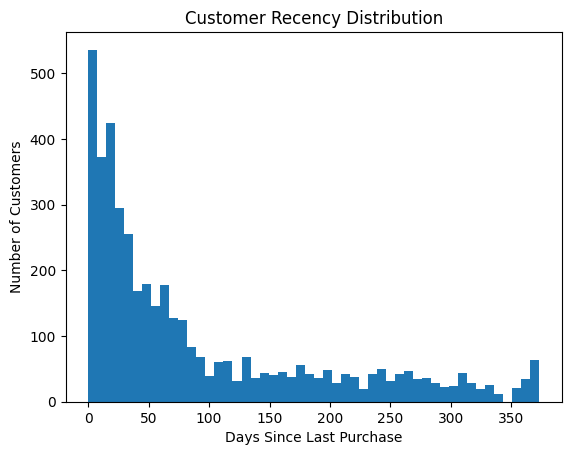

In [12]:
analysis_date=sales_with_date["date"].max() #end of dataset
customer_recency=sales_with_date.groupby("customer_id")["date"].max().reset_index(name='last_purchase_date') 
customer_recency["recency_day"]=(analysis_date- customer_recency["last_purchase_date"]).dt.days #calculating customer customer recency

#plotting recency
plt.figure()
plt.hist(customer_recency["recency_day"], bins=50)
plt.xlabel("Days Since Last Purchase")
plt.ylabel("Number of Customers")
plt.title("Customer Recency Distribution")
plt.show()


<p>the purchase recency distribution above shows the substancial variability among customers</p>

### EDA Summary and Motivation for RFM

Exploratory data analysis reveals substantial heterogeneity in customer behavior. 
Customer recency varies widely, indicating differing levels of recent engagement. 
Purchase frequency also shows a highly skewed distribution, with many infrequent buyers and a small group of highly frequent purchasers. 
Customer-level revenue is strongly right-skewed, with a small proportion of customers contributing a disproportionate share of total revenue. 
These patterns motivate the use of Recency, Frequency, and Monetary (RFM) analysis.
